# Acknowledgements

- Dataset from https://github.com/ieee8023/covid-chestxray-dataset
- COVID-19 Detector code from https://github.com/JordanMicahBennett/SMART-CT-SCAN_BASED-COVID19_VIRUS_DETECTOR/

# Imports

In [1]:
import pandas as pd
import os

In [2]:
# General libraries
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt

# Deep learning libraries
#import keras.backend as K
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Add 
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation, ZeroPadding2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

#Util Component 1: Confusion matrix report/Accuracy measures
from sklearn.metrics import accuracy_score, confusion_matrix

# disabling warnings
import logging
logging.getLogger('tensorflow').disabled = True #Jordan_note: Disable red warning lines seen at model architecture creation.

# Utility Functions

In [3]:
def renderConfusionMetrics ( ___model, _testData, _testLabels, enableTraining, ___train_gen, ___test_gen, __batch_size, __epochs, hdf5_testSaveFileName ):
    preds = ___model.predict(_testData)

    acc = accuracy_score(_testLabels, np.round(preds))*100
    cm = confusion_matrix(_testLabels, np.round(preds))
    tn, fp, fn, tp = cm.ravel()


    print('\nCONFUSION MATRIX FORMAT ------------------\n')
    print("[true positives    false positives]")
    print("[false negatives    true negatives]\n\n")

    print('CONFUSION MATRIX ------------------')
    print(cm)

    print('\nTEST METRICS ----------------------')
    precision = tp/(tp+fp)*100
    recall = tp/(tp+fn)*100
    specificity = tn/(tn+fp)*100 #Jordan_note: added specificity calculation 
    print('Accuracy: {}%'.format(acc))
    print('Precision: {}%'.format(precision))
    print('Recall/Sensitivity: {}%'.format(recall)) #Jordan_note: added sensitivity label
    print('Specificity {}%'.format(specificity)) #Jordan_note: added specificity calculation 
    print('F1-score: {}'.format(2*precision*recall/(precision+recall)))


    if enableTraining:
        checkpoint = ModelCheckpoint(filepath=hdf5_testSaveFileName, save_best_only=True, save_weights_only=True)
        lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
        early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')


        hist = ___model.fit_generator(
                   ___train_gen, steps_per_epoch=___test_gen.samples // __batch_size, 
                   epochs=__epochs, validation_data=___test_gen, 
                   validation_steps=___test_gen.samples // __batch_size, callbacks=[checkpoint, lr_reduce])

        print('\nTRAIN METRIC ----------------------')
        print('Covid19 Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()
    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(hist.history[met])
        ax[i].plot(hist.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
    plt.savefig('train_val_acc_loss.png')

In [4]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [5]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [6]:
def ResNet50(_img_dims, classes = 1):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    input_shape = (_img_dims, _img_dims, 3)
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2, 2))(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='sigmoid', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    inputs = X_input
    output = X
    # Create model
    #model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return inputs,output

def process_data(___inputPath, img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory=___inputPath+'train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory=___inputPath+'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    
    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(___inputPath + 'test' + cond)):
            img = cv2.imread(___inputPath+'test'+cond+img,0) #Replace plt.imread, with  gray scale cv2.imread(path,0), so that ui's image load process doesn't throw a pyimage10 error
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

def reportFileDistributions (___inputPath, directoryProcessArray):
    for _set in directoryProcessArray:
        n_normal = len(os.listdir(___inputPath + _set + '/NORMAL'))
        n_infect = len(os.listdir(___inputPath + _set + '/PNEUMONIA'))
        print('Set: {}, normal images: {}, regular pneumonia images: {}'.format(_set, n_normal, n_infect))

In [7]:
# Setting seeds for reproducibility
seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

In [8]:
# Hyperparameters
img_dims = 150
batch_size = 32

In [12]:
inputs, output = ResNet50(img_dims, classes = 1)
# inputs, output = defineModelArchitecture (img_dims )

# Non-COVID-19 Lung Pneumonia Detection

In [13]:
# Creating model and compiling
model_pneumoniaDetector = Model(inputs=inputs, outputs=output)
model_pneumoniaDetector.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_pneumoniaDetector.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 156, 156, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 75, 75, 64)   256         conv1[0][0]                      
______________________________________________________________________________________________

In [14]:
input_path_b = '../input/chest-xray-pneumonia/chest_xray/chest_xray/'

In [15]:
# Report file distributions
reportFileDistributions (input_path_b, ['train', 'val', 'test'] )

Set: train, normal images: 1342, regular pneumonia images: 3876
Set: val, normal images: 9, regular pneumonia images: 9
Set: test, normal images: 234, regular pneumonia images: 390


In [16]:
# Getting the data
train_gen, test_gen, test_data_b, test_labels_b = process_data(input_path_b, img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.



CONFUSION MATRIX FORMAT ------------------

[true positives    false positives]
[false negatives    true negatives]


CONFUSION MATRIX ------------------
[[  0 234]
 [  0 390]]

TEST METRICS ----------------------
Accuracy: 62.5%
Precision: 62.5%
Recall/Sensitivity: 100.0%
Specificity 0.0%
F1-score: 76.92307692307692
Train for 19 steps, validate for 19 steps
Epoch 1/10
19/19 [==============================] - 158s 8s/step - loss: 2.8343 - accuracy: 0.7105 - val_loss: 0.6702 - val_accuracy: 0.6234
Epoch 2/10
19/19 [==============================] - 147s 8s/step - loss: 0.6492 - accuracy: 0.7812 - val_loss: 0.9391 - val_accuracy: 0.6234
Epoch 3/10
19/19 [==============================] - 142s 7s/step - loss: 0.6426 - accuracy: 0.8224 - val_loss: 1.1743 - val_accuracy: 0.6234
Epoch 4/10
19/19 [==============================] - 142s 7s/step - loss: 0.3272 - accuracy: 0.8668 - val_loss: 1.4535 - val_accuracy: 0.6234
Epoch 5/10
19/19 [==============================] - 141s 7s/step - loss: 0

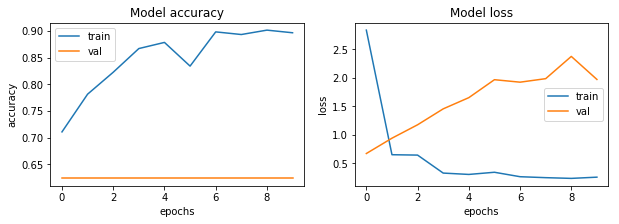

In [17]:
renderConfusionMetrics(model_pneumoniaDetector, test_data_b, test_labels_b, True, train_gen, test_gen, batch_size, 10, 'model_weights.hdf5')

# COVID-19 Lung Pneumonia Detection

In [18]:
inputs, output = ResNet50(img_dims, classes = 1)

# Creating model and compiling
model_covid19PneumoniaDetector = Model(inputs=inputs, outputs=output)
model_covid19PneumoniaDetector.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_covid19PneumoniaDetector.load_weights('model_weights.hdf5')

In [19]:
input_path_d = '../input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/'

In [20]:
reportFileDistributions (input_path_d, ['train', 'test'])

Set: train, normal images: 74, regular pneumonia images: 74
Set: test, normal images: 20, regular pneumonia images: 20


In [21]:
train_gen_d, test_gen_d, test_data_d, test_labels_d = process_data(input_path_d, img_dims, batch_size)

Found 148 images belonging to 2 classes.
Found 40 images belonging to 2 classes.



CONFUSION MATRIX FORMAT ------------------

[true positives    false positives]
[false negatives    true negatives]


CONFUSION MATRIX ------------------
[[ 0 20]
 [ 0 20]]

TEST METRICS ----------------------
Accuracy: 50.0%
Precision: 50.0%
Recall/Sensitivity: 100.0%
Specificity 0.0%
F1-score: 66.66666666666667
Train for 1 steps, validate for 1 steps
Epoch 1/10
1/1 [==============================] - 17s 17s/step - loss: 3.8273 - accuracy: 0.3500 - val_loss: 19.1162 - val_accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 8s 8s/step - loss: 0.9835 - accuracy: 0.6000 - val_loss: 262.2407 - val_accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 12s 12s/step - loss: 0.4400 - accuracy: 0.8125 - val_loss: 454.0264 - val_accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 11s 11s/step - loss: 2.0152 - accuracy: 0.6875 - val_loss: 408.9824 - val_accuracy: 0.5000
Epoch 5/10

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.000300000014

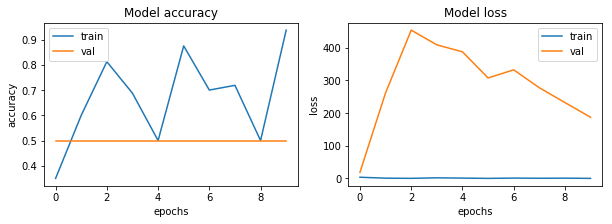

In [22]:
renderConfusionMetrics(model_covid19PneumoniaDetector, test_data_d, test_labels_d, True, train_gen_d, test_gen_d, batch_size, 10, 'covid19_model_weights.hdf5')

# References

[1] Joseph Paul Cohen and Paul Morrison and Lan Dao. COVID-19 image data collection, arXiv, 2020. https://github.com/ieee8023/covid-chestxray-dataset

[2] https://github.com/JordanMicahBennett/SMART-CT-SCAN_BASED-COVID19_VIRUS_DETECTOR/